# 과제2. [평가]Mobile 고객 이탈 분석

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 데이터분석을 의뢰하였습니다.
* 고객 이탈여부(CHURN)에 영향을 주는 요인을 찾아 봅시다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

### 2) 데이터 로딩

In [2]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
mobile = pd.read_csv(data_path)
# mobile.drop(['id', 'REPORTED_USAGE_LEVEL','OVER_15MINS_CALLS_PER_MONTH'], axis = 1, inplace = True)
mobile.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0)	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간(분)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' )	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it')	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	Label	|


----

## 1.가설수립

* 숫자형 최소 3개이상, 범주형 최소 2개 이상씩, 전체 6개의 변수를 도출, 가설을 수립하시오.

----

## 2.단변량 분석

① 변수의 비즈니스 의미  

② 숫자? 범주?  

③ 전처리 사항
   - NaN 존재 여부 및 조치 방안  
   - 가변수화 대상여부  
   
④ 기초통계량

⑤ 분포  

⑥ 위 정보로부터 파악한 내용(비즈니스!) 정리  

⑦ 추가 분석해볼 사항 도출

## 3.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 유의수준 : 5%
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.


In [3]:
target = 'CHURN'

### (1) 범주형 Feature --> CHURN
* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 교차표(pd.crosstab())  
    ② 시각화( Stacked Bar, Mosaic)  
    ③ 가설검정(카이제곱검정)
* 각 feature 별로 관계의 정도를 3가지로 정리해봅시다. 

#### 1) COLLEGE --> CHURN

In [4]:
var = 'COLLEGE'

① 교차표(pd.crosstab())

In [5]:
pd.crosstab(mobile[target], mobile[var])

COLLEGE,0,1
CHURN,,
0,4616,4515
1,4335,4534


② 시각화(Stacked Bar, Mosaic)

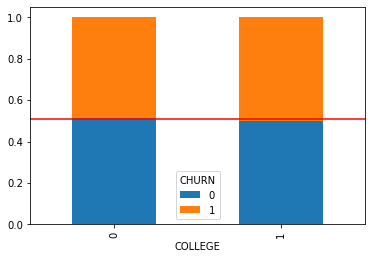

In [6]:
bar_table = pd.crosstab(mobile[var], mobile[target], normalize = 'index')

bar_table.plot.bar(stacked=True)
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

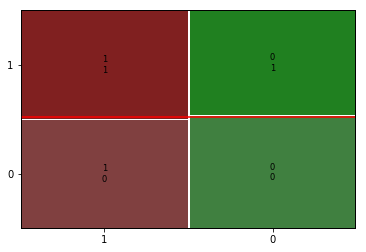

In [7]:
# Pclass별 생존여부를 mosaic plot으로 그려 봅시다.
mosaic(mobile, [var,target])
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

③ 가설검정(카이제곱검정)

In [8]:
# 먼저 집계
table = pd.crosstab(mobile[target], mobile[var])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 COLLEGE     0     1
CHURN              
0        4616  4515
1        4335  4534
----------------------------------------------------------------------------------------------------
카이제곱통계량 4.982102934693503
p-value 0.025610833478220536
기대빈도
 [[4540.64338889 4590.35661111]
 [4410.35661111 4458.64338889]]


④ 결론

#### 2) REPORTED_SATISFACTION --> CHURN

In [9]:
var = 'REPORTED_SATISFACTION'

① 교차표(pd.crosstab())

In [10]:
pd.crosstab(mobile[target], mobile[var])

REPORTED_SATISFACTION,avg,sat,unsat,very_sat,very_unsat
CHURN,,,,,
0,952,492,1792,2334,3543
1,854,440,1798,2228,3529


② 시각화(Stacked Bar, Mosaic)

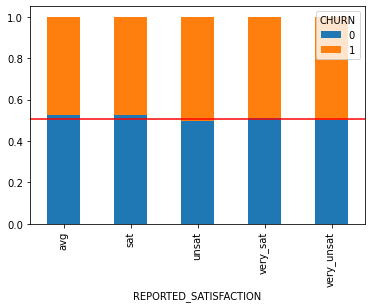

In [11]:
bar_table = pd.crosstab(mobile[var], mobile[target], normalize = 'index')

bar_table.plot.bar(stacked=True)
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

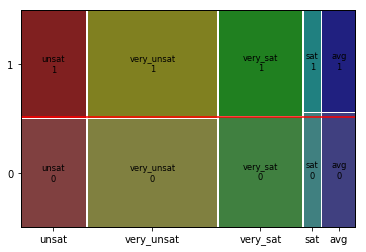

In [12]:
# Pclass별 생존여부를 mosaic plot으로 그려 봅시다.
mosaic(mobile, [var,target])
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

③ 가설검정(카이제곱검정)

In [13]:
# 먼저 집계
table = pd.crosstab(mobile[target], mobile[var])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 REPORTED_SATISFACTION  avg  sat  unsat  very_sat  very_unsat
CHURN                                                       
0                      952  492   1792      2334        3543
1                      854  440   1798      2228        3529
----------------------------------------------------------------------------------------------------
카이제곱통계량 6.8411009572056445
p-value 0.14452738878905066
기대빈도
 [[ 916.27201871  472.84912593 1821.38236277 2314.5254426  3587.97104999]
 [ 889.72798129  459.15087407 1768.61763723 2247.4745574  3484.02895001]]


④ 결론

#### 3) CONSIDERING_CHANGE_OF_PLAN --> CHURN

In [14]:
var = 'CONSIDERING_CHANGE_OF_PLAN'

① 교차표(pd.crosstab())

In [15]:
pd.crosstab(mobile[target], mobile[var])

CONSIDERING_CHANGE_OF_PLAN,actively_looking_into_it,considering,never_thought,no,perhaps
CHURN,,,,,
0,2278,3648,926,1823,456
1,2175,3493,878,1821,502


② 시각화(Stacked Bar, Mosaic)

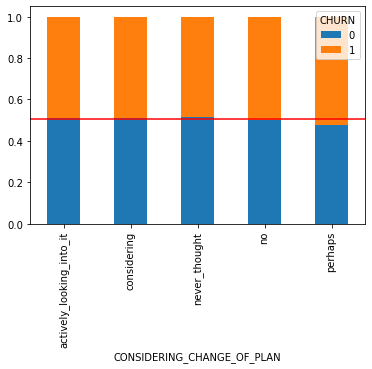

In [16]:
bar_table = pd.crosstab(mobile[var], mobile[target], normalize = 'index')

bar_table.plot.bar(stacked=True)
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

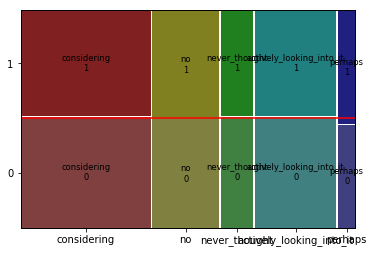

In [17]:
# Pclass별 생존여부를 mosaic plot으로 그려 봅시다.
mosaic(mobile, [var,target])
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

③ 가설검정(카이제곱검정)

In [18]:
# 먼저 집계
table = pd.crosstab(mobile[target], mobile[var])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 CONSIDERING_CHANGE_OF_PLAN  actively_looking_into_it  considering  \
CHURN                                                               
0                                               2278         3648   
1                                               2175         3493   

CONSIDERING_CHANGE_OF_PLAN  never_thought    no  perhaps  
CHURN                                                     
0                                     926  1823      456  
1                                     878  1821      502  
----------------------------------------------------------------------------------------------------
카이제곱통계량 5.421434419620689
p-value 0.2467222586679969
기대빈도
 [[2258.90794444 3622.47061111  915.12911111 1848.52022222  485.97211111]
 [2194.09205556 3518.52938889  888.87088889 1795.47977778  472.02788889]]


④ 결론

### (2) 숫자형 Feature --> CHURN

* 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 그래프 : histogram, densityplot   
    ② 수치화 : 로지스틱회귀

#### 1) INCOME --> CHURN


In [19]:
var = 'INCOME'

① 그래프 : histogram, densityplot

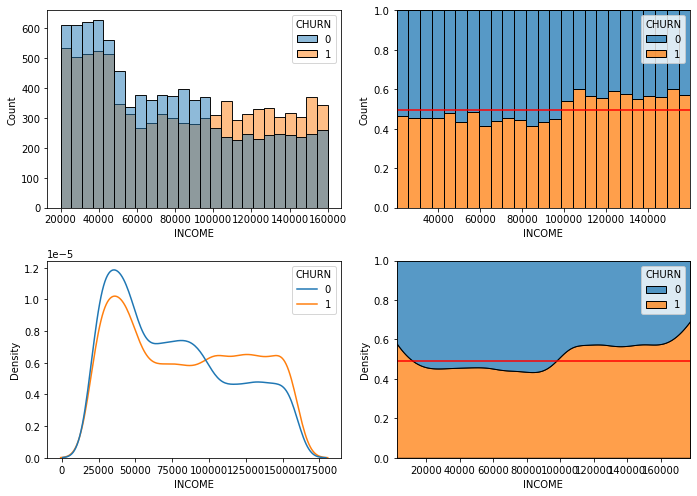

In [20]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.histplot(x=var, data = mobile, hue = target)

plt.subplot(2,2,2)
sns.histplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(2,2,3)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(2,2,4)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.tight_layout()
plt.show()

② 수치화 : 로지스틱 회귀

In [21]:
# 로지스틱 모형을 만들고 통계량을 구해 봅시다.
tmp = mobile[mobile[var].notna()]
model = sm.Logit(tmp[target], tmp[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692683
         Iterations 2
INCOME    0.000044
dtype: float64


③ 결과

#### 2) OVERAGE --> CHURN


In [22]:
var = 'OVERAGE'

① 그래프 : histogram, densityplot

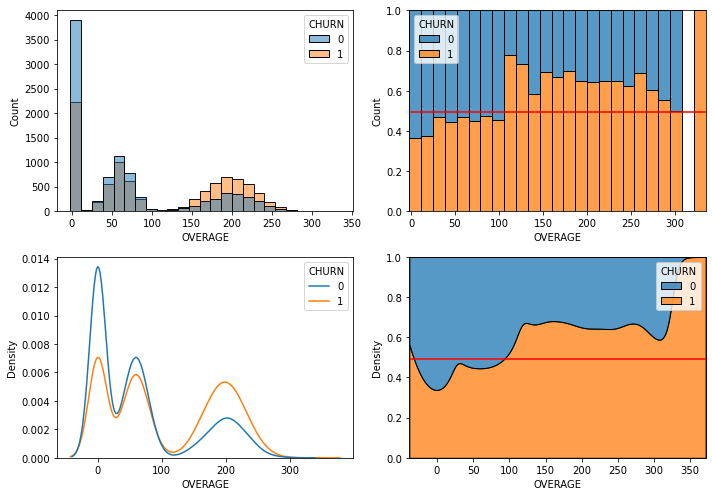

In [23]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.histplot(x=var, data = mobile, hue = target)

plt.subplot(2,2,2)
sns.histplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(2,2,3)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(2,2,4)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.tight_layout()
plt.show()

② 수치화 : 로지스틱 회귀

In [24]:
# 로지스틱 모형을 만들고 통계량을 구해 봅시다.
tmp = mobile[mobile[var].notna()]
model = sm.Logit(tmp[target], tmp[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.680553
         Iterations 4
OVERAGE    3.521095e-97
dtype: float64


③ 결과

#### 3) LEFTOVER --> CHURN


In [25]:
var = 'LEFTOVER'

① 그래프 : histogram, densityplot

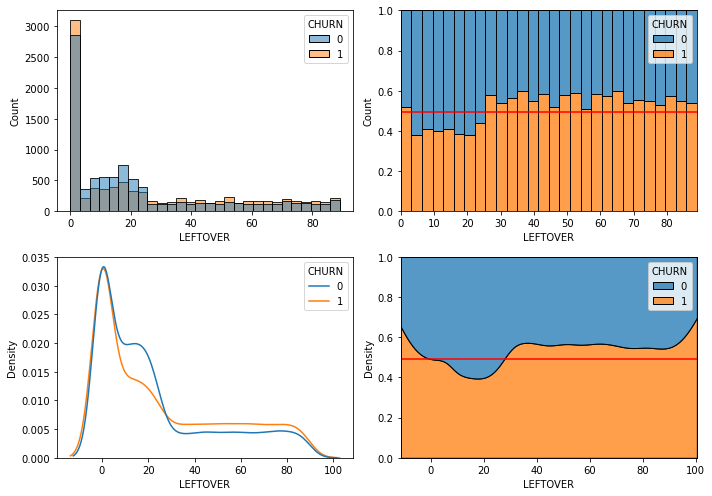

In [26]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.histplot(x=var, data = mobile, hue = target)

plt.subplot(2,2,2)
sns.histplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(2,2,3)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(2,2,4)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.tight_layout()
plt.show()

② 수치화 : 로지스틱 회귀

In [27]:
# 로지스틱 모형을 만들고 통계량을 구해 봅시다.
tmp = mobile[mobile[var].notna()]
model = sm.Logit(tmp[target], tmp[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692532
         Iterations 3
LEFTOVER    0.000003
dtype: float64


③ 결과

#### 4) HOUSE --> CHURN


In [28]:
var = 'HOUSE'

① 그래프 : histogram, densityplot

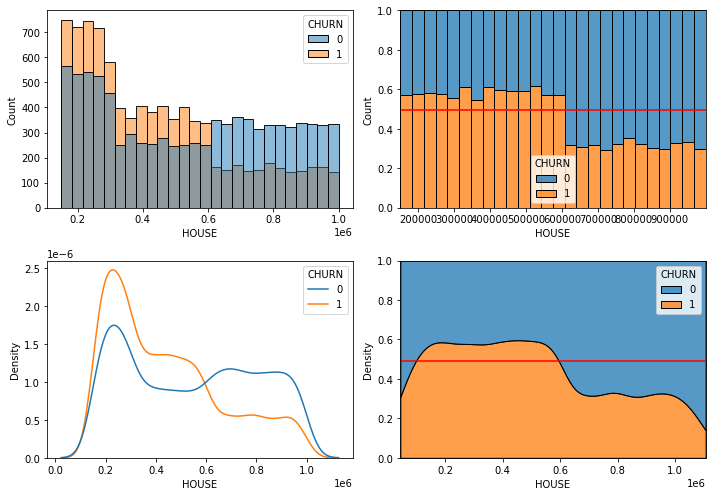

In [29]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.histplot(x=var, data = mobile, hue = target)

plt.subplot(2,2,2)
sns.histplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(2,2,3)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(2,2,4)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.tight_layout()
plt.show()

② 수치화 : 로지스틱 회귀

In [30]:
# 로지스틱 모형을 만들고 통계량을 구해 봅시다.
tmp = mobile[mobile[var].notna()]
model = sm.Logit(tmp[target], tmp[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.687266
         Iterations 2
HOUSE    6.401120e-47
dtype: float64


③ 결과

#### 5) HANDSET_PRICE --> CHURN


In [31]:
var = 'HANDSET_PRICE'

① 그래프 : histogram, densityplot

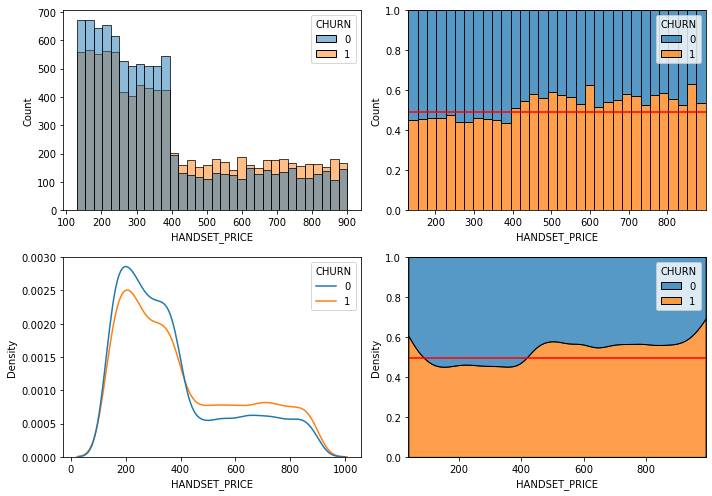

In [32]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.histplot(x=var, data = mobile, hue = target)

plt.subplot(2,2,2)
sns.histplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(2,2,3)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(2,2,4)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.tight_layout()
plt.show()

② 수치화 : 로지스틱 회귀

In [33]:
# 로지스틱 모형을 만들고 통계량을 구해 봅시다.
tmp = mobile[mobile[var].notna()]
model = sm.Logit(tmp[target], tmp[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692730
         Iterations 3
HANDSET_PRICE    0.000107
dtype: float64


③ 결과

#### 6) AVERAGE_CALL_DURATION --> CHURN


In [34]:
var = 'HANDSET_PRICE'

① 그래프 : histogram, densityplot

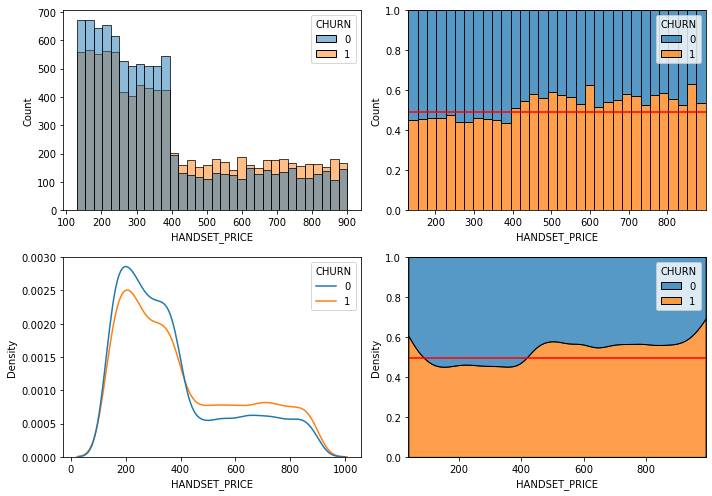

In [35]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.histplot(x=var, data = mobile, hue = target)

plt.subplot(2,2,2)
sns.histplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(2,2,3)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(2,2,4)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.tight_layout()
plt.show()

② 수치화 : 로지스틱 회귀

In [36]:
# 로지스틱 모형을 만들고 통계량을 구해 봅시다.
tmp = mobile[mobile[var].notna()]
model = sm.Logit(tmp[target], tmp[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692730
         Iterations 3
HANDSET_PRICE    0.000107
dtype: float64


③ 결과

## 5.추가 분석

In [37]:
num_col = []
for i in mobile.columns :
    if mobile[i].dtype != 'object' :
        num_col.append(i)

In [38]:
num_col.remove('COLLEGE')
num_col.remove('CHURN')
try :
    num_col.remove('id')
except :
    pass

In [39]:
num_col

['INCOME',
 'OVERAGE',
 'LEFTOVER',
 'HOUSE',
 'HANDSET_PRICE',
 'OVER_15MINS_CALLS_PER_MONTH',
 'AVERAGE_CALL_DURATION']

In [40]:
target = 'REPORTED_SATISFACTION'

In [41]:
tmp = mobile[mobile[target].notna()]

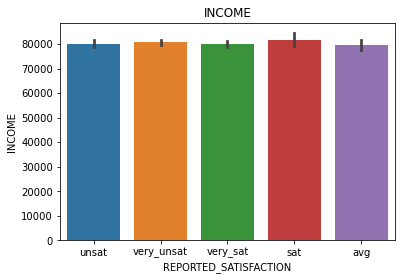

F_onewayResult(statistic=0.6276308880488041, pvalue=0.6427587680003393)


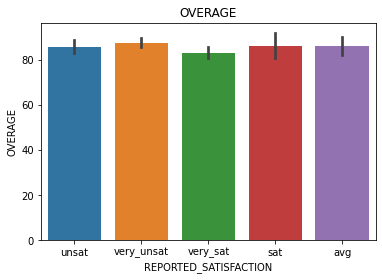

F_onewayResult(statistic=1.9476958337994252, pvalue=0.09959953886540703)


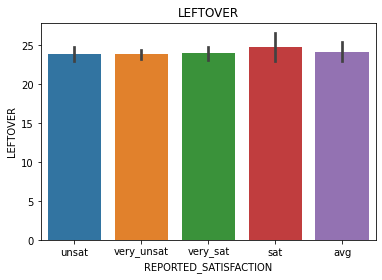

F_onewayResult(statistic=0.2842755396647721, pvalue=0.8883373437212166)


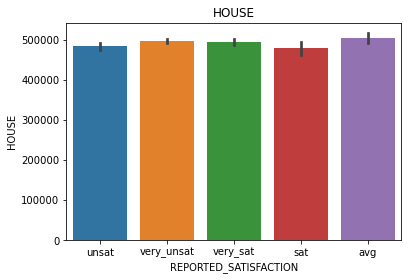

F_onewayResult(statistic=2.967773776573603, pvalue=0.018361942267068564)


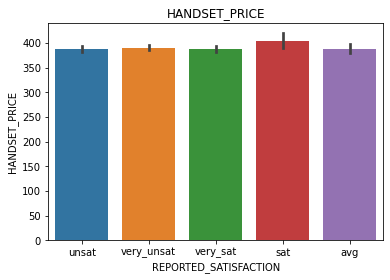

F_onewayResult(statistic=1.2642152566425775, pvalue=0.28155621076780063)


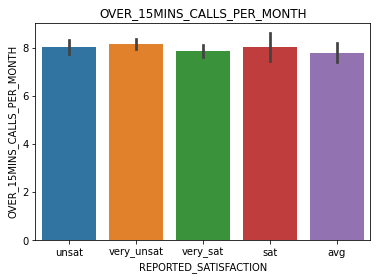

F_onewayResult(statistic=1.0545161950448014, pvalue=0.37733099882391496)


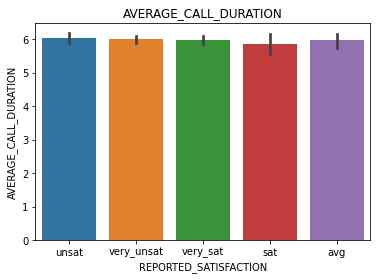

F_onewayResult(statistic=0.27913520522210605, pvalue=0.8916346324952892)


In [42]:
for i in num_col :
    # sns.barplot는 두 범주의 평균 비교 sns.barplot
    sns.barplot(x=target, y=i, data=mobile)
    plt.title(i)
    plt.show()
    
    tmp2 = mobile[mobile[i].notna()]
    
    p = []
    for j in tmp[target].unique() :
        p.append(tmp2.loc[tmp2[target] == j, i])

    print(spst.f_oneway(p[0], p[1], p[2], p[3], p[4]))

In [43]:
target = 'CONSIDERING_CHANGE_OF_PLAN'

In [44]:
tmp = mobile[mobile[target].notna()]

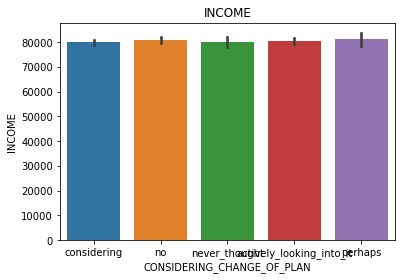

F_onewayResult(statistic=0.3747691480455073, pvalue=0.8268013299591586)


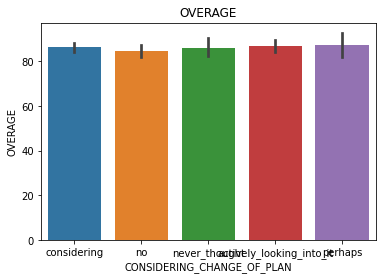

F_onewayResult(statistic=0.45371496498177205, pvalue=0.7697608471091132)


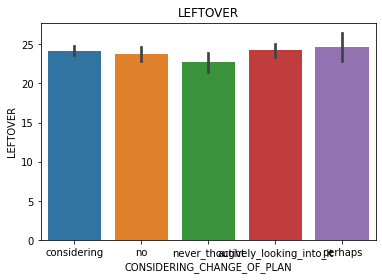

F_onewayResult(statistic=1.3567791102201157, pvalue=0.24625715584323915)


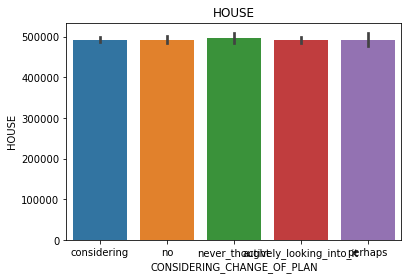

F_onewayResult(statistic=0.2312843763956853, pvalue=0.9209229870119086)


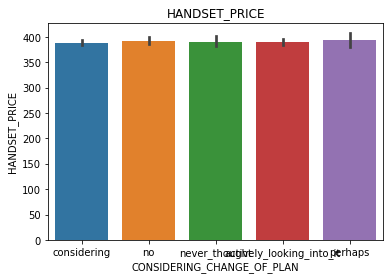

F_onewayResult(statistic=0.3394235244734219, pvalue=0.851509459429497)


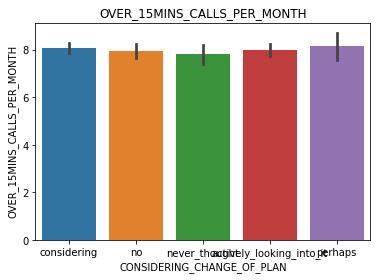

F_onewayResult(statistic=0.43630282404423715, pvalue=0.7824872345195614)


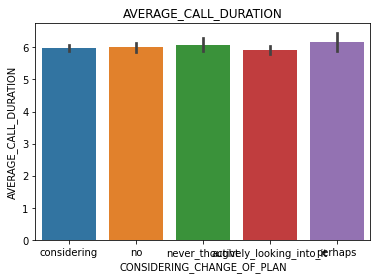

F_onewayResult(statistic=0.9032957445991228, pvalue=0.46090256346820047)


In [45]:
for i in num_col :
    # sns.barplot는 두 범주의 평균 비교 sns.barplot
    sns.barplot(x=target, y=i, data=mobile)
    plt.title(i)
    plt.show()
    
    tmp2 = mobile[mobile[i].notna()]
    
    p = []
    for j in tmp[target].unique() :
        p.append(tmp2.loc[tmp2[target] == j, i])

    print(spst.f_oneway(p[0], p[1], p[2], p[3], p[4]))

In [46]:
target = 'REPORTED_USAGE_LEVEL'

In [47]:
tmp = mobile[mobile[target].notna()]

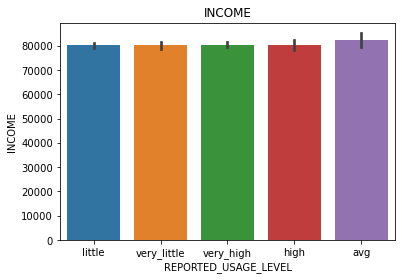

F_onewayResult(statistic=0.6194668476928993, pvalue=0.6486092206154955)


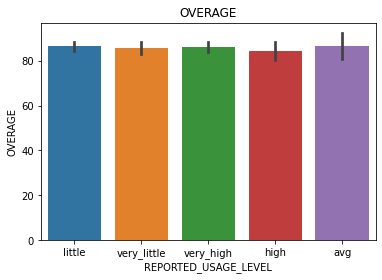

F_onewayResult(statistic=0.19943108485803995, pvalue=0.938749321711485)


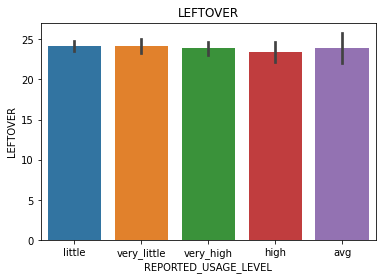

F_onewayResult(statistic=0.2898416494548051, pvalue=0.8847378576696916)


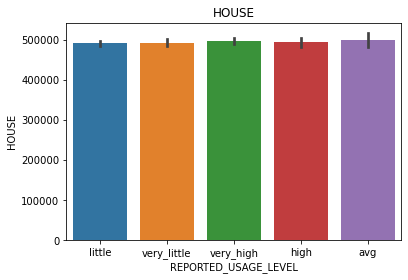

F_onewayResult(statistic=0.5198188087540638, pvalue=0.7211816136512939)


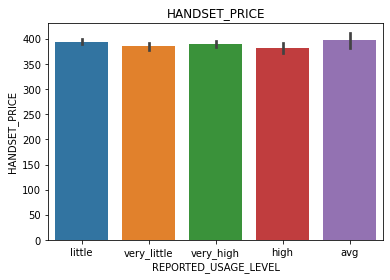

F_onewayResult(statistic=2.0703660050913624, pvalue=0.08184282802243752)


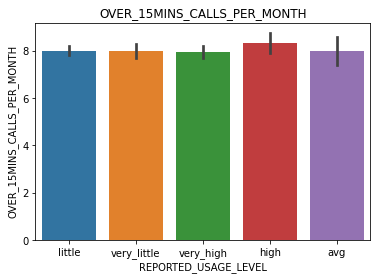

F_onewayResult(statistic=0.6200011753496206, pvalue=0.6482257390122419)


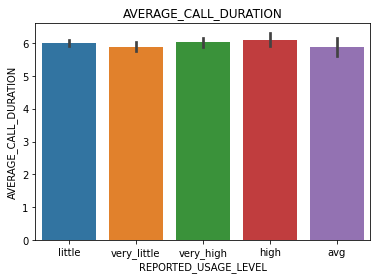

F_onewayResult(statistic=0.9460281583414458, pvalue=0.4360374323055769)


In [48]:
for i in num_col :
    # sns.barplot는 두 범주의 평균 비교 sns.barplot
    sns.barplot(x=target, y=i, data=mobile)
    plt.title(i)
    plt.show()
    
    tmp2 = mobile[mobile[i].notna()]
    
    p = []
    for j in tmp[target].unique() :
        p.append(tmp2.loc[tmp2[target] == j, i])

    print(spst.f_oneway(p[0], p[1], p[2], p[3], p[4]))

#### 3) CONSIDERING_CHANGE_OF_PLAN --> REPORTED_SATISFACTION

In [49]:
target = 'REPORTED_SATISFACTION'
var = 'CONSIDERING_CHANGE_OF_PLAN'

① 교차표(pd.crosstab())

In [50]:
pd.crosstab(mobile[target], mobile[var])

CONSIDERING_CHANGE_OF_PLAN,actively_looking_into_it,considering,never_thought,no,perhaps
REPORTED_SATISFACTION,,,,,
avg,469,687,194,373,83
sat,231,367,89,193,52
unsat,910,1402,350,753,175
very_sat,1112,1816,473,924,237
very_unsat,1724,2850,694,1396,408


② 시각화(Stacked Bar, Mosaic)

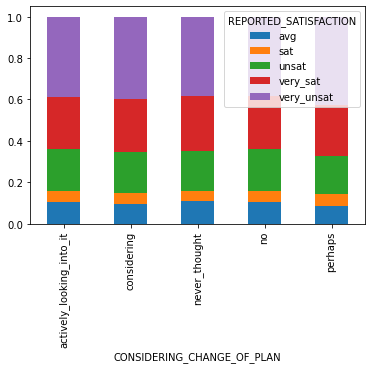

In [51]:
bar_table = pd.crosstab(mobile[var], mobile[target], normalize = 'index')

bar_table.plot.bar(stacked=True)
plt.show()

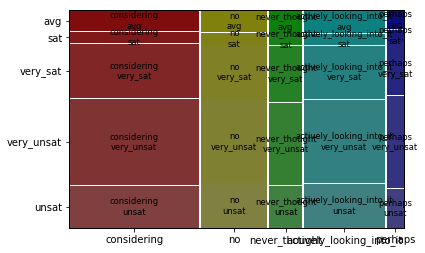

In [52]:
# Pclass별 생존여부를 mosaic plot으로 그려 봅시다.
mosaic(mobile, [var,target])
plt.show()

③ 가설검정(카이제곱검정)

In [53]:
# 먼저 집계
table = pd.crosstab(mobile[target], mobile[var])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 CONSIDERING_CHANGE_OF_PLAN  actively_looking_into_it  considering  \
REPORTED_SATISFACTION                                               
avg                                              469          687   
sat                                              231          367   
unsat                                            910         1402   
very_sat                                        1112         1816   
very_unsat                                      1724         2850   

CONSIDERING_CHANGE_OF_PLAN  never_thought    no  perhaps  
REPORTED_SATISFACTION                                     
avg                                   194   373       83  
sat                                    89   193       52  
unsat                                 350   753      175  
very_sat                              473   924      237  
very_unsat                            694  1396      408  
--------------------------------------------------------------------------------------------------

④ 결론

In [54]:
mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           18000 non-null  int64  
 1   COLLEGE                      18000 non-null  int64  
 2   INCOME                       18000 non-null  int64  
 3   OVERAGE                      18000 non-null  int64  
 4   LEFTOVER                     18000 non-null  int64  
 5   HOUSE                        17785 non-null  float64
 6   HANDSET_PRICE                18000 non-null  int64  
 7   OVER_15MINS_CALLS_PER_MONTH  18000 non-null  int64  
 8   AVERAGE_CALL_DURATION        18000 non-null  int64  
 9   REPORTED_SATISFACTION        17962 non-null  object 
 10  REPORTED_USAGE_LEVEL         18000 non-null  object 
 11  CONSIDERING_CHANGE_OF_PLAN   18000 non-null  object 
 12  CHURN                        18000 non-null  int64  
dtypes: float64(1), i

**COLLEGE+REPORTED_SATISFACTION**

In [85]:
mobile['REPORTED_SATISFACTION_NUM'] = 0
mobile.loc[mobile['REPORTED_SATISFACTION']=='unsat', 'REPORTED_SATISFACTION_NUM'] = 1
mobile.loc[mobile['REPORTED_SATISFACTION']=='avg', 'REPORTED_SATISFACTION_NUM'] = 2
mobile.loc[mobile['REPORTED_SATISFACTION']=='sat', 'REPORTED_SATISFACTION_NUM'] = 3
mobile.loc[mobile['REPORTED_SATISFACTION']=='very_sat', 'REPORTED_SATISFACTION_NUM'] = 4

In [87]:
tmp = mobile[mobile['REPORTED_SATISFACTION'].notna()]

print(tmp['COLLEGE'].unique())
print(tmp['REPORTED_SATISFACTION_NUM'].unique())

[1 0]
[1 0 4 3 2]


In [88]:
mobile['COL_SAT'] = np.nan

In [89]:
tmp.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN,COL_SAT,COL_CHANPLAN,REPORTED_SATISFACTION_NUM
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0,1_unsat,1_considering,1
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1,0_unsat,0_no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0,1_unsat,1_considering,1
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0,0_very_unsat,0_never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1,1_unsat,1_no,1


In [91]:
for i in tmp['COLLEGE'].unique() :
    for j in tmp['REPORTED_SATISFACTION_NUM'].unique() :
        mobile.loc[(mobile['COLLEGE']==i)&(mobile['REPORTED_SATISFACTION_NUM']==j), 'COL_SAT'] = str(i)+'_'+str(j)
        
mobile.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN,COL_SAT,COL_CHANPLAN,REPORTED_SATISFACTION_NUM
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0,1_1,1_considering,1
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1,0_1,0_no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0,1_1,1_considering,1
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0,0_0,0_never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1,1_1,1_no,1


In [92]:
target = 'CHURN'
var = 'COL_SAT'

① 교차표(pd.crosstab())

In [93]:
pd.crosstab(mobile[target], mobile[var])

COL_SAT,0_0,0_1,0_2,0_3,0_4,1_0,1_1,1_2,1_3,1_4
CHURN,,,,,,,,,,
0,1793,905,506,248,1164,1768,887,446,244,1170
1,1742,899,384,206,1104,1807,899,470,234,1124


② 시각화(Stacked Bar, Mosaic)

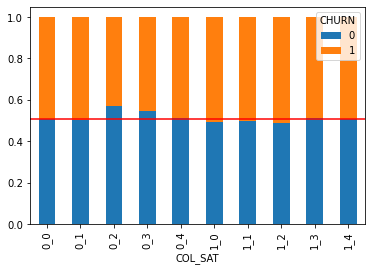

In [94]:
bar_table = pd.crosstab(mobile[var], mobile[target], normalize = 'index')

bar_table.plot.bar(stacked=True)
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

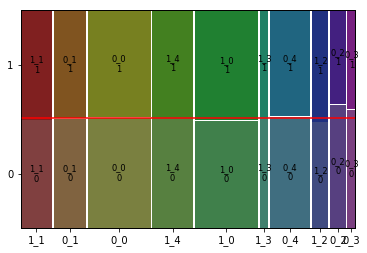

In [95]:
# Pclass별 생존여부를 mosaic plot으로 그려 봅시다.
mosaic(mobile, [var,target])
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

③ 가설검정(카이제곱검정)

In [96]:
# 먼저 집계
tmp = mobile
table = pd.crosstab(mobile[target], mobile[var])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 COL_SAT   0_0  0_1  0_2  0_3   0_4   1_0  1_1  1_2  1_3   1_4
CHURN                                                        
0        1793  905  506  248  1164  1768  887  446  244  1170
1        1742  899  384  206  1104  1807  899  470  234  1124
----------------------------------------------------------------------------------------------------
카이제곱통계량 21.409594584163035
p-value 0.010950816110796782
기대빈도
 [[1793.22694444  915.12911111  451.47722222  230.30411111 1150.506
  1813.51805556  905.99811111  464.66644444  242.47877778 1163.69522222]
 [1741.77305556  888.87088889  438.52277778  223.69588889 1117.494
  1761.48194444  880.00188889  451.33355556  235.52122222 1130.30477778]]


④ 결론

**COLLEGE+CONSIDERING_CHANGE_OF_PLAN**

In [64]:
# tmp = mobile[mobile['REPORTED_SATISFACTION'].notna()]

print(mobile['COLLEGE'].unique())
print(mobile['CONSIDERING_CHANGE_OF_PLAN'].unique())

[1 0]
['considering' 'no' 'never_thought' 'actively_looking_into_it' 'perhaps']


In [65]:
mobile['COL_CHANPLAN'] = np.nan

In [66]:
mobile.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN,COL_SAT,COL_CHANPLAN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0,1_unsat,NaN
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1,0_unsat,NaN
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0,1_unsat,NaN
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0,0_very_unsat,NaN
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1,1_unsat,NaN


In [67]:
for i in mobile['COLLEGE'].unique() :
    for j in mobile['CONSIDERING_CHANGE_OF_PLAN'].unique() :
        mobile.loc[(mobile['COLLEGE']==i)&(mobile['CONSIDERING_CHANGE_OF_PLAN']==j), 'COL_CHANPLAN'] = str(i)+'_'+j
        
mobile.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN,COL_SAT,COL_CHANPLAN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0,1_unsat,1_considering
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1,0_unsat,0_no
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0,1_unsat,1_considering
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0,0_very_unsat,0_never_thought
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1,1_unsat,1_no


In [80]:
target = 'CHURN'
var = 'COL_CHANPLAN'

① 교차표(pd.crosstab())

In [81]:
pd.crosstab(mobile[target], mobile[var])

COL_CHANPLAN,0_actively_looking_into_it,0_considering,0_never_thought,0_no,0_perhaps,1_actively_looking_into_it,1_considering,1_never_thought,1_no,1_perhaps
CHURN,,,,,,,,,,
0,1189,1830,461,910,226,1089,1818,465,913,230
1,1092,1693,423,878,249,1083,1800,455,943,253


② 시각화(Stacked Bar, Mosaic)

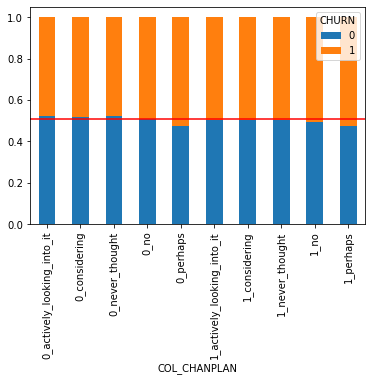

In [82]:
bar_table = pd.crosstab(mobile[var], mobile[target], normalize = 'index')

bar_table.plot.bar(stacked=True)
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

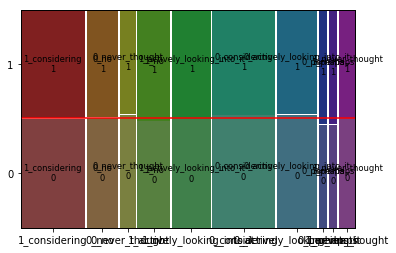

In [83]:
# Pclass별 생존여부를 mosaic plot으로 그려 봅시다.
mosaic(mobile, [var,target])
plt.axhline(1-mobile[target].mean(), color = 'r')
plt.show()

③ 가설검정(카이제곱검정)

In [84]:
# 먼저 집계
table = pd.crosstab(mobile[target], mobile[var])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 COL_CHANPLAN  0_actively_looking_into_it  0_considering  0_never_thought  \
CHURN                                                                      
0                                   1189           1830              461   
1                                   1092           1693              423   

COL_CHANPLAN  0_no  0_perhaps  1_actively_looking_into_it  1_considering  \
CHURN                                                                      
0              910        226                        1089           1818   
1              878        249                        1083           1800   

COL_CHANPLAN  1_never_thought  1_no  1_perhaps  
CHURN                                           
0                         465   913        230  
1                         455   943        253  
----------------------------------------------------------------------------------------------------
카이제곱통계량 10.756079882809194
p-value 0.2927997078171244
기대빈도
 [[1157.10061111 1787.1396111

④ 결론

#### 1) INCOME --> COLLEGE


In [73]:
target = 'COLLEGE'
var = 'INCOME'

① 그래프 : histogram, densityplot

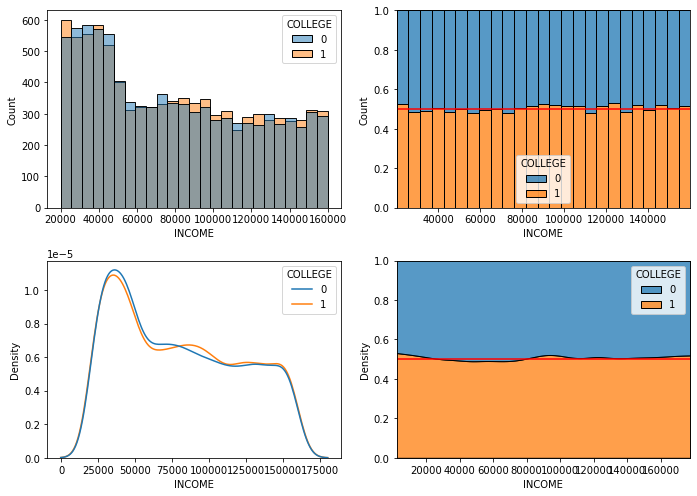

In [74]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.histplot(x=var, data = mobile, hue = target)

plt.subplot(2,2,2)
sns.histplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(2,2,3)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(2,2,4)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.tight_layout()
plt.show()

② 수치화 : 로지스틱 회귀

In [75]:
# 로지스틱 모형을 만들고 통계량을 구해 봅시다.
tmp = mobile[mobile[var].notna()]
model = sm.Logit(tmp[target], tmp[var])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 2
INCOME    0.211635
dtype: float64


③ 결과

**COLLEGE-->INCOME**

In [76]:
target = 'INCOME'
var = 'COLLEGE'

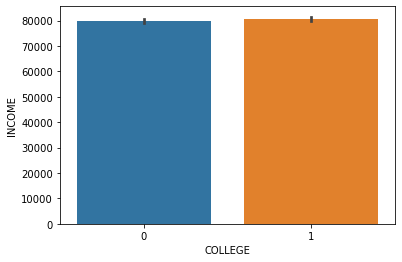

In [77]:
# sns.barplot는 두 범주의 평균 비교 sns.barplot
sns.barplot(x=var, y=target, data=mobile)
plt.show()

In [78]:
grade = mobile.loc[mobile[var] == 1, target]
ungrade = mobile.loc[mobile[var] == 0, target]

In [79]:
spst.ttest_ind(grade, ungrade)

Ttest_indResult(statistic=1.3038720567985258, pvalue=0.1922938851766671)